In [5]:
# DO NOT TOUCH!!!

import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as itertools
import numpy as np

etfs = pd.read_csv('etfs/half_filtered_etfs.csv', header = None, names = ['ETF'], skiprows = [0])

tickers = etfs["ETF"].tolist()

start_date = '2015-01-01'
end_date = '2020-01-01'

data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]

prices = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_5268/193806565.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  209 of 209 completed


In [ ]:
# rolling cointegration

window_size = 252
min_passes = 0.4
step = 21

candidate_pairs = []
cointegrated_pairs = []

category_prices = prices[tickers]

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        candidate_pairs.append([tickers[i], tickers[j]])

for etf1, etf2 in candidate_pairs:
            
    df = category_prices[[etf1, etf2]].dropna()

    series1 = df.iloc[:, 0]
    series2 = df.iloc[:, 1]

    cointegrated_windows = 0
    total_windows = 0

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size

        window_s1 = series1.iloc[start:end]
        window_s2 = series2.iloc[start:end]
                
        score, pvalue, _ = coint(window_s1, window_s2)
        total_windows += 1
                
        if pvalue < 0.1:
            cointegrated_windows += 1

    if cointegrated_windows / total_windows >= min_passes:
        cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})
    print(f'ETF1: {etf1}, ETF2: {etf2}, Pass %: {cointegrated_windows / total_windows}')

cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs)

cointegrated_pairs_df = cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop = True)
print(f'Rolling Cointegrated Pairs:')
cointegrated_pairs_df.head()

ETF1: IWS, ETF2: VYM, Pass %: 0.14583333333333334
ETF1: IWS, ETF2: SDY, Pass %: 0.14583333333333334
ETF1: IWS, ETF2: MTUM, Pass %: 0.16666666666666666
ETF1: IWS, ETF2: IUSV, Pass %: 0.2916666666666667
ETF1: IWS, ETF2: IWN, Pass %: 0.08333333333333333
ETF1: IWS, ETF2: SPHD, Pass %: 0.0625
ETF1: IWS, ETF2: VTV, Pass %: 0.2708333333333333
ETF1: IWS, ETF2: DGRO, Pass %: 0.16666666666666666
ETF1: IWS, ETF2: SPLG, Pass %: 0.08333333333333333
ETF1: IWS, ETF2: USMV, Pass %: 0.0625
ETF1: IWS, ETF2: MDY, Pass %: 0.3541666666666667
ETF1: IWS, ETF2: SCHX, Pass %: 0.0625
ETF1: IWS, ETF2: FV, Pass %: 0.08333333333333333
ETF1: IWS, ETF2: SCHV, Pass %: 0.22916666666666666
ETF1: IWS, ETF2: IWD, Pass %: 0.3125
ETF1: IWS, ETF2: SCHA, Pass %: 0.10416666666666667
ETF1: IWS, ETF2: VTWO, Pass %: 0.041666666666666664
ETF1: IWS, ETF2: SCHD, Pass %: 0.16666666666666666
ETF1: IWS, ETF2: SPY, Pass %: 0.10416666666666667
ETF1: IWS, ETF2: DVY, Pass %: 0.2708333333333333
ETF1: IWS, ETF2: IJR, Pass %: 0.0416666666666

,ETF1,ETF2,Pass %
0,IWM,SPSM,0.770833
1,SPLG,IWB,0.750000
2,SPY,VOO,0.750000
3,IVW,SPYG,0.750000
4,VTWO,SPSM,0.750000


In [6]:
category_prices = prices[tickers]
returns = category_prices.pct_change().dropna()

In [3]:
import numpy as np
import statsmodels.api as sm

CORR_252_MAX = 0.98
CORR_060_MAX = 0.98
USE_ABS_CORR = True

def trailing_corr(returns, t1, t2, window):
    r1 = returns[t1].dropna()
    r2 = returns[t2].dropna()
    r = pd.concat([r1, r2], axis=1, join='inner').dropna()
    if len(r) < window:
        return np.nan
    c = r.iloc[-window:].corr().iloc[0,1]
    return abs(c) if USE_ABS_CORR else c

def apply_corr_filter(cointegrated_pairs_df, returns):
    rows = []
    for t1, t2 in cointegrated_pairs_df[['ETF1','ETF2']].itertuples(index=False):
        c252 = trailing_corr(returns, t1, t2, 252)
        c060 = trailing_corr(returns, t1, t2, 60)
        keep = (c252 < CORR_252_MAX) and (c060 < CORR_060_MAX)
        rows.append({'ETF1': t1, 'ETF2': t2, 'corr_252': c252, 'corr_060': c060, 'keep_corr': keep})
    metrics = pd.DataFrame(rows)

    out = cointegrated_pairs_df.merge(metrics, on=['ETF1','ETF2'], how='left')
    filtered = out[out['keep_corr']].sort_values(by=['corr_252','corr_060'])
    return filtered, out

corr_filtered_pairs_df, corr_metrics_df = apply_corr_filter(cointegrated_pairs_df, returns)
print("Kept after correlation filter:", len(corr_filtered_pairs_df), "of", len(cointegrated_pairs_df))
corr_filtered_pairs_df.head(19)

NameError: name 'cointegrated_pairs_df' is not defined

In [21]:
newetfs = []
keyetfs = ['ETF1','ETF2']

for i in keyetfs:
    for j in corr_filtered_pairs_df[i]:
        newetfs.append(j)

unique_newetfs = set(newetfs)
unique_newetfs = list(unique_newetfs)

print(unique_newetfs)

new_returns = prices[unique_newetfs].pct_change().dropna()


['VYM', 'VTV', 'IWS', 'RSP', 'VO', 'OEF', 'DIA', 'FVD', 'IJH', 'VOO', 'DVY', 'IWB', 'SCHX', 'SPHQ', 'SPLG', 'IVV', 'SPY', 'SCHV', 'IWR']


Clusters:
     ETF  Cluster        PC1        PC2
0    IJR        1 -25.225917 -30.974802
1   MTUM        0   2.741542  27.573406
2    SPY        0   6.930335   8.991656
3   ARKK        1 -87.373339  51.612294
4   IUSV        0   9.129478  -8.511046
5   SPYG        0   1.832270  24.000827
6   ITOT        0   2.654430   5.749021
7    RSP        0   3.724411  -4.753990
8   QUAL        0   8.805400  10.246361
9   SCHV        0  14.615930  -3.073220
10    FV        0 -17.698286  15.685692
11   VOO        0   6.516561   9.216749
12  DGRO        0  14.997490   1.550893
13   IWM        1 -29.627027 -24.669774
14   HDV        0  29.989549  -4.242677
15   IWS        0   3.914877 -15.992734
16   IWF        0  -2.423255  23.238596
17  FNDA        1 -16.532513 -27.278964
18  SCHD        0  19.666198   1.356022
19  SPHD        0  25.799920 -13.239122
20   SDY        0  17.521888 -12.516923
21  IUSG        0  -0.681725  20.870497
22   IJH        1 -10.333768 -17.009889
23   VYM        0  18.262584  

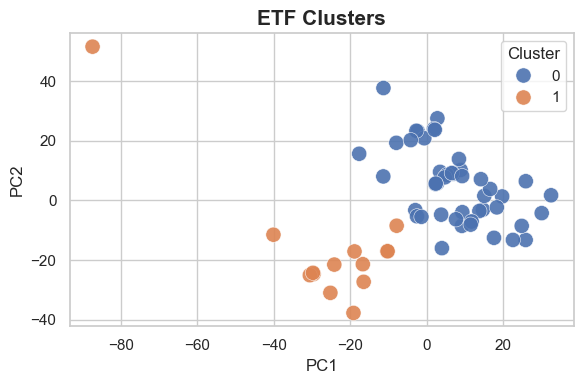

In [8]:
# k-means / PCA

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.T)

pca = PCA(n_components = 2)
pca_components = pca.fit_transform(returns_scaled)

max_clusters = min(len(etfs) - 1, 10)

best_k = 3
best_score = -1

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)

    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters = best_k, random_state = 42)
labels = kmeans.fit_predict(pca_components)

cluster_df = pd.DataFrame({
    'ETF': returns.columns,
    'Cluster': labels,
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1]
})

print(f'Clusters:')
print(cluster_df.to_string())

sns.set_theme(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (6, 4))

sns.scatterplot(
    data = cluster_df,
    x = 'PC1',        
    y = 'PC2',
    hue = 'Cluster',
    s = 120, 
    linewidth = 0.4,
    alpha = 0.9 
)

plt.title(f'ETF Clusters', fontsize = 15, weight = 'bold')
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.legend(title = 'Cluster', loc='upper right', frameon = True)

plt.tight_layout()
plt.show()

cluster_df = cluster_df.sort_values(by = 'Cluster')

In [24]:
final_candidates = []

cluster_zip = dict(zip(cluster_df['ETF'], cluster_df['Cluster']))

for _, row in corr_filtered_pairs_df.iterrows():
    etf1, etf2, pass_percentage = row['ETF1'], row['ETF2'], row['Pass %']
    if cluster_zip[etf1] == cluster_zip[etf2]:
        final_candidates.append([etf1, etf2, pass_percentage, cluster_zip[etf1]])

final_candidates = pd.DataFrame(final_candidates, columns=['ETF1', 'ETF2', 'RC Pass %', 'Cluster #'])
final_candidates = final_candidates.sort_values('RC Pass %', ascending = False).reset_index(drop = True)
print(final_candidates)


    ETF1  ETF2  RC Pass %  Cluster #
0     VO   IWB   0.583333          1
1     VO   SPY   0.541667          1
2     VO  SCHX   0.520833          1
3     VO  SPLG   0.520833          1
4     VO   IVV   0.500000          1
5     VO   VOO   0.500000          1
6    DVY   IWR   0.479167          1
7   SCHV  SPHQ   0.479167          1
8    IWR   DIA   0.458333          1
9    DVY   OEF   0.437500          1
10   VTV  SPHQ   0.437500          1
11   RSP   DIA   0.437500          1
12    VO   DIA   0.416667          1
13   DVY   FVD   0.416667          1
14   DVY   VYM   0.416667          1


In [4]:
final_candidates = pd.read_csv('etfs/cointegrated_pairs.csv')

In [7]:
used_universe = pd.unique(final_candidates[['ETF1', 'ETF2']].values.ravel())
unused_universe = [etf for etf in tickers if etf not in used_universe]

CORR_MAX = 0.97

def pairs_corr(a, b):
    if a not in returns.columns or b not in returns.columns:
        return np.nan

    s1 = returns[a]
    s2 = returns[b]
    idx = s1.index.intersection(s2.index)

    if len(idx) < 252:
        return np.nan
    
    corr = s1.loc[idx].corr(s2.loc[idx])

    return corr

filtered_universe = []
for etf in unused_universe:
    if all(pairs_corr(etf, p) < CORR_MAX for p in used_universe):
        filtered_universe.append(etf)

unused_pairs = list(itertools.combinations(filtered_universe, 2))
filtered_pairs = [
    pair for pair in unused_pairs
    if pairs_corr(pair[0], pair[1]) < CORR_MAX
]

seed = np.random.default_rng(42)

if len(filtered_pairs) < 10:
    raise RuntimeError("Not enough non-clone ETF pairs after filtering")

random_pairs = seed.choice(len(filtered_pairs), size = 15, replace = False)
random_pairs = [filtered_pairs[i] for i in random_pairs]

print("15 randomly sampled pairs from unused ETF universe:")
print(random_pairs)

print("Unused ETFs:", len(unused_universe))
print("After pipeline-similarity filter:", len(filtered_universe))
print("Candidate random pairs:", len(filtered_pairs))

for a,b in random_pairs:
    print(a,b,pairs_corr(a,b))

random_pairs = pd.DataFrame(random_pairs, columns = ['ETF1', 'ETF2'])
random_pairs.to_csv('etfs/half_filtered_etf_pairs.csv', index = False)

15 randomly sampled pairs from unused ETF universe:
[('VTWV', 'VTWO'), ('VTWV', 'PEY'), ('VBK', 'SMLV'), ('SPGP', 'RWK'), ('SPTM', 'VBK'), ('SPMD', 'SLYV'), ('VTWV', 'XMLV'), ('GRPM', 'PKW'), ('SIZE', 'VTWG'), ('PBW', 'VBR'), ('MMTM', 'FTCS'), ('TILT', 'GURU'), ('ISCG', 'DDIV'), ('FDM', 'IUSG'), ('DGRO', 'XSVM')]
Unused ETFs: 192
After pipeline-similarity filter: 145
Candidate random pairs: 10373
VTWV VTWO 0.9532280599789856
VTWV PEY 0.8249977780977599
VBK SMLV 0.8394057557804486
SPGP RWK 0.8174509740287171
SPTM VBK 0.9124709357935556
SPMD SLYV 0.8405298834621414
VTWV XMLV 0.7319783773905533
GRPM PKW 0.8922645910922868
SIZE VTWG 0.8191891864763144
PBW VBR 0.7851623877353845
MMTM FTCS 0.6442243271092172
TILT GURU 0.8230951300925474
ISCG DDIV 0.6320371945799302
FDM IUSG 0.7605979924382609
DGRO XSVM 0.7526183199385925


In [27]:
cluster_pairs = list(itertools.combinations((used_universe), 2))

def used_pair(a, b):
    return tuple(sorted((a, b)))

used_pairs = {
    used_pair(row.ETF1, row.ETF2) for _, row in final_candidates.iterrows()
}
valid_pairs = [i for i in cluster_pairs if used_pair(*i) not in used_pairs]

seed = np.random.default_rng(42)
num = min(10, len(valid_pairs))
random_cluster_pairs = [cluster_pairs[i] for i in seed.choice(len(valid_pairs), size = num, replace = False)]

print('10 randomly sampled pairs from pipeline ETF cluster:')
print(random_cluster_pairs)

10 randomly sampled pairs from pipeline ETF cluster:
[('VO', 'DIA'), ('VOO', 'VTV'), ('VO', 'SPHQ'), ('IVV', 'SPHQ'), ('SCHX', 'SCHV'), ('SPHQ', 'DIA'), ('VOO', 'IWR'), ('VO', 'OEF'), ('IWB', 'SPHQ'), ('IWR', 'SCHV')]
